In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
import importlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scipy.optimize
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

Will solve the following equations in one dimension

$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $$

$$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$$

$$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$$

Following then the continuity equation in 1D

$$
\begin{align}
\frac{\partial \rho}{\partial t} &= -\frac{\partial \rho u}{\partial x} \\
\end{align}
$$

But in order to solve this we must first numerically solve $\frac{\partial \rho u}{\partial x}$

$$
\begin{align}
\frac{\partial \rho u}{\partial x} &= \left(u \frac{\partial \rho}{\partial x} + \rho \frac{\partial u}{\partial x}\right)
\end{align}
$$
And the LHS becomes
$$
\begin{align}
\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1} - \rho^n}{\Delta t}
\end{align}
$$
Then 
$$
\rho^{n+1} = \rho^n - \Delta t \left(u^n \left[\frac{\partial \rho}{\partial x}\right]^n + \rho^n \left[\frac{\partial u}{\partial x}\right]^n\right)
$$
Where the brackets represent the derivative scheme, which is going to be dependent on the flow direction

Now for the momentum equation

$$
\begin{align}
\frac{\partial (\rho \mathbf{u})}{\partial t} + \nabla \cdot (\rho \mathbf{u} \otimes \mathbf{u}) = -\nabla (P_g)
\end{align}
$$
In one dimension we have then
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \frac{\partial \left(\rho u^2\right)}{\partial x} = -\frac{\partial}{\partial x} (P_g)
\end{align}
$$

We have already done the first term, so the second term with the help of product rule becomes
$$
\begin{align}
\frac{\partial \left(\rho u^2\right)}{\partial x} &= \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}
\end{align}
$$
This turns the momentum equation into
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}= -\frac{\partial}{\partial x} (P_g)
\end{align}
$$
Discretized
$$
\begin{align}
\left[\frac{\partial (\rho u)}{\partial t}\right]^n =- \left[\rho u\right]^n \left[\frac{\partial u}{\partial x}\right]^n - u^n\left[\frac{\partial (\rho u)}{\partial x}\right]^n-\left[\frac{\partial}{\partial x} (P_g)\right]^n
\end{align}
$$
But this is also aprroximated to
$$
\left[\frac{\partial \rho u}{\partial t}\right]^n \approx \frac{\left[\rho u\right]^{n+1} - \left[\rho u\right]^n}{\Delta t}
$$
Meaning we get
$$
u^{n+1} = \frac{\left[\rho u\right]^n + \left[\frac{\partial \rho u}{\partial t}\right]^n \Delta t}{\rho^{n+1}}\
$$
Where again we must be carefull of which scheme to use on $\frac{\partial \rho u}{\partial t}$

Lastly the energy equation

$$
\frac{\partial e}{\partial t} = - \frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x}
$$
RHS turns into
$$
-\frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x} = -(e + P) \frac{\partial u}{\partial x} - u\frac{\partial e}{\partial x}
$$
So energy
$$
e^{n+1} = e^n + \left[\frac{\partial e}{\partial t}\right]^n \Delta t
$$

Only LAX method in Julia, start with implenting just Python.

Hint from tor. Make Lax in SOD Laxer

1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt

In [2]:
def e_step(xx, uu, e, Pg, dt):
    """
    Returns the e^{n+1} in the energy equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    e   : `array`
        Energy function that depends on xx
    Pg  : `array`
        Pressure function that depend on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for e^{n+1}
    """
    # Implementing the upwind and downwind in one line
    term1 = nm.deriv_upw(xx, e)
    term2 = nm.deriv_dnw(xx, e)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu<0)]
    else:
        term2 = np.zeros_like(term1)
        
    ddx_e = term1 + term2
    
    # Calculate the derivative
    ddt_e = -(e + Pg)*nm.deriv_cent(xx, uu) - uu*ddx_e
    ennt = e + ddt_e*dt
    return ennt
    
def rho_step(xx, uu, rho, dt):
    """
    Returns the rho^{n+1} in the momentum equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    rho : `array`
        Density function that depends on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    term1 = nm.deriv_upw(xx, rho) #[np.where(uu>=0)]
    term2 = nm.deriv_dnw(xx, rho) #[np.where(uu<0)]
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rho = term1 + term2
    ddx_u = nm.deriv_cent(xx, uu)
    rho_nnt = rho - dt*(uu*ddx_rho + rho*ddx_u)
    # Avijeet did something smart
    return rho_nnt
    
def lax_method(xx, hh, dt, dx, bnd_limits=[0, 1], bnd_type="wrap"):
    N = len(xx)
    ans = np.zeros(N)
    term1 = np.roll(hh, -1) + np.roll(hh, 1)
    term2 = np.roll(hh, -1) - np.roll(hh, 1)
    frac = (hh*dt) / (2*dx)
    tmmp = 0.5*term1 - frac*term2
    # For upwind and centre
    if bnd_limits[1] > 0:
        ans = np.pad(tmmp[bnd_limits[0]: -bnd_limits[1]], bnd_limits, bnd_type)
    # For downwind
    else:
        ans = np.pad(tmmp[bnd_limits[0]:], bnd_limits, bnd_type)
    return ans


def ddt_rhou(xx, uu, P, rhou):
    """
    Returns the rhs for the ddt_rhou equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    P : `array`
        Pressure function that depends on xx
    rhou : `array`
        Momentum function that depends on xx

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    ddx_u = nm.deriv_cent(xx, uu)
    term1 = nm.deriv_upw(xx, rhou)
    term2 = nm.deriv_dnw(xx, rhou)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rhou = term1 + term2
    ddx_P = nm.deriv_cent(xx, P)
    
    ans = -rhou*ddx_u - uu*ddx_rhou - ddx_P
    return ans

def u_step(xx, uu, rho, P, dt):
    """
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.

    Returns
    -------
    """
    rhou = rho*uu
    dd_rhou = ddt_rhou(xx, uu, P, rhou)
    rho_nnt = rho_step(xx, uu, rho, dt)
    
    unnt = (rhou + dd_rhou*dt)/rho_nnt 
    return unnt
    
def bifrost_6th(xx, hh):
    c = 3/640
    b = 1/24 - 3*c
    a = 1 - 3*b + 5*c

    dx = np.gradient(xx)

    term1 = a/dx*(hh - np.roll(hh, -1))
    term2 = b/dx*(np.roll(hh, 1) - np.roll(hh, -2))
    term3 = c/dx*(np.roll(hh, 2) - np.roll(hh, -3))
    
    rhs = term1 + term2 + term3
    return rhs
    
def flux_limiter(xx, hh, lamba):
    """Lax simple scheme"""
    pass

def P(e, rho, γ=5/3):
    """
    Calculates the Pressure

    Parameters:
    -----------
    e
    """
    prod = e#/rho
    ans = (γ - 1)*prod
    return ans

def initialise(nx, ny, nz, nt, P0, rho0, γ=5/3):

    if (ny == 1) and (nz == 1):
        N = nx
    else:
        N = (nx, ny, nz)
    Pg = np.zeros((N, nt))
    rho = np.zeros((N, nt))
    u = np.zeros((N, nt))
    moment = np.zeros((N, nt))
    e = np.zeros((N, nt))
    
    Pg[0:int(nx/2), 0] = P0[0]
    Pg[int(nx/2):, 0] = P0[1]

    rho[0:int(nx/2), 0] = rho0[0]
    rho[int(nx/2):, 0] = rho0[1]
    
    e[:, 0] = Pg[:, 0]/(γ - 1)
    
    return Pg, rho, e, moment
    
def calc_dt(cs, u, xx, cfl_cut=0.98):
    dt1 = cfl_cut*nm.cfl_adv_burger(u + cs, xx)
    dt2 = cfl_cut*nm.cfl_adv_burger(u, xx)
    return np.min([dt1, dt2])

def calculate_cs(P, rho, γ, eps=1e-10):
    cs = np.sqrt(γ*P/(rho + eps))
    return cs
    

def init_array(nx, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((nx, nt)) 
    Pg = np.zeros((nx, nt))   
    moment = np.zeros((nx, nt))
    rho = np.zeros((nx, nt))
    u = np.zeros((nx, nt))
    
    e[:, 0] = e0
    Pg[:, 0] = P0
    rho[:, 0] = rho0
    u[:, 0] = u0
    moment[:, 0] = u0*rho0
    return Pg, e, moment, rho, u

# TODO combine init_array and init_array3D to one
def init_array3D(nx, ny, nz, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((nx, ny, nz,  nt)) 
    Pg = np.zeros((nx, ny, nz,  nt))   
    moment = np.zeros((nx, ny, nz,  nt))
    rho = np.zeros((nx, ny, nz,  nt))
    u = np.zeros((nx, ny, nz,  nt))
    
    idx = (..., 0)
    
    e[idx] = e0
    Pg[idx] = P0
    rho[idx] = rho0
    u[idx] = u0
    moment[idx] = u0*rho0
    return Pg, e, moment, rho, u
    
def solver3D(nx, ny, nz, xx, yy, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1]):
    Pg, e, moment, rho, u = init_array(nx, ny, nz, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    for i in range(0, nt-1):
        idx = (..., i)
        u = moment[idx]/(rho[idx] + eps)
        Pg_temp = Pg[idx]

        cs = np.sqrt(γ * Pg_temp/(rho[idx] + eps))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs = - ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[idx], -1) + rho[idx] + np.roll(rho[idx], 1))/ 3.
            moment_lax = (np.roll(moment[idx], -1) + moment[idx] + np.roll(moment[idx], 1))/ 3.
            e_lax = (np.roll(e[idx], -1) + e[idx] + np.roll(e[idx], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        idx_next = (..., i+1)
        rho[idx_next] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[idx_next] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[idx_next] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg_temp = (γ - 1)*e[idx_next]
        Pg[idx_next] = Pg_temp
        
        time[i+1] = time[i] + dt
        
    return Pg, rho, moment, e, time

def solver(nx, ny, nz, xx, nt, P0, rho0, u0=None, e0=None, 
           γ=5/3, cfl_cut=0.2,
           ddx=lambda x, y: nm.deriv_dnw(x, y), method='FTCS', 
           bnd_type='wrap', bnd_limits=[0,1], sod=None):
    """
    Need sound speed
    """
    Pg, e, moment, rho, u = init_array(nx, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1.e-10
    for i in range(0, nt-1):
        """ Trying the indexing
        u = moment[:, i] / (rho[:, i] + eps)
        Pg_temp = Pg[:, i]
        cs = np.sqrt(γ * Pg_temp/(rho[:, i] + eps))
        """
        idx = (slice(None), i)
        u = moment[idx] / (rho[idx] + eps)
        Pg_temp = Pg[idx]
        cs = np.sqrt(γ * Pg_temp/(rho[idx] + eps))
        #cfl condition
        dt = cfl_cut*np.min(np.gradient(xx)/ (np.abs(u) + cs + eps))
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[:, i] + rho_rhs*dt
            moment_temp = moment[:, i] + moment_rhs*dt
            e_temp = e[:, i] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[:, i], -1) + rho[:, i] + np.roll(rho[:, i], 1))/ 3.
            moment_lax = (np.roll(moment[:, i], -1) + moment[:, i] + np.roll(moment[:, i], 1))/ 3.
            e_lax = (np.roll(e[:, i], -1) + e[:, i] + np.roll(e[:, i], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # up and centre
            rho_bc = rho_temp[:][bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        rho[:, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[:, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg_temp = (γ - 1)*e[:, i+1]
        Pg[:, i+1] = Pg_temp
        
        time[i+1] = time[i] + dt
        
        
    return Pg, rho, moment, e, time
    

def gauss(xx, A, mu, sigma, C):
    ans = A*np.exp(-.5*(xx - mu)**2/sigma**2) + C
    return ans

In [3]:
def animation(xx, tt, ut, rhot, Pgt, nt, figsize=(10, 5)):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    def init():
        axes.plot(xx, ut[:, 0], label='u')
        axes.plot(xx, rhot[:, 0], label='rho')
        axes.plot(xx, Pgt[:, 0], label='P')
        axes.set_ylim(-0.1, 1.1)
        axes.set_xlim(min(xx), max(xx))
        axes.legend()
    
    def animate(i):
        axes.clear()
        axes.plot(xx, ut[:, i], label='u')
        axes.plot(xx, rhot[:, i], label='rho')
        axes.plot(xx, Pgt[:, i], label='P')
        axes.set_ylim(-0.1, 1.1)
        axes.set_xlim(min(xx), max(xx))
        axes.legend()
        axes.set_title(f't={tt[i]:.2f}')
        
    anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
    return anim

Test with gaussian profile

In [25]:
γ = 5/3
nt = 100
nx, ny, nz = 512, 1, 1
xx = nm.spatial_domain(nx, x0=0, xf=1)

In [26]:
u0 = np.zeros(nx)+0.01
e0 = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.1)) + 0.1
Pg0 = (γ - 1)*e0 
rho0 = np.ones(nx)#gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.01)) + 0.1

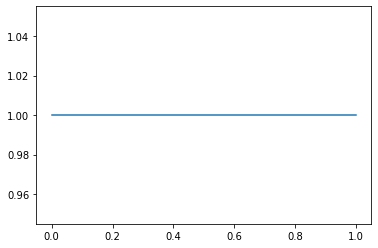

In [27]:
plt.plot(xx, rho0)

In [28]:
Pg1D, rho1D, moment1D, e1D, time1D = solver(nx, ny, nz, xx, nt, Pg0, rho0, u0, e0, method='FTCS')
u1D = moment1D/rho1D

/tmp/ipykernel_10826/4144236125.py:341: RuntimeWarning: invalid value encountered in sqrt
  cs = np.sqrt(γ * Pg_temp/(rho[idx] + eps))


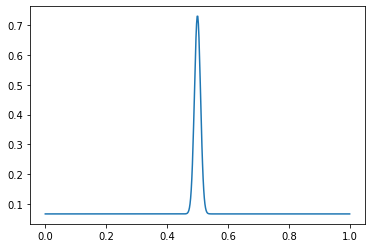

In [29]:
plt.plot(xx, Pg1D[:, 1])

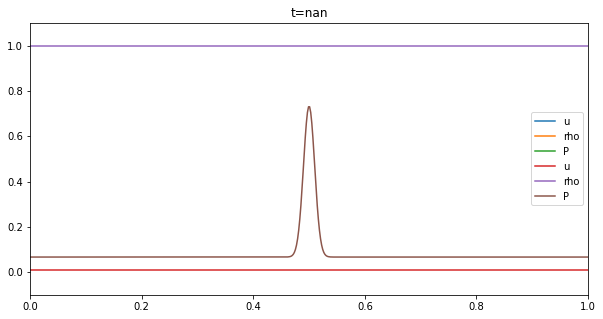

In [30]:
anim = animation(xx, time1D, u1D, rho1D, Pg1D, nt)
HTML(anim.to_jshtml())

In [10]:
nx = 1024
γ = 5/3
xx = nm.spatial_domain(nx, x0=0., xf=1.)
nx2 = int(nx/2)
ny, nz = 1, 1
nt = 100

PL = 1.0
PR = 0.1
u0 = np.zeros(nx)+0.01
e0 = np.zeros(nx)+0.01
e0[:nx2] = PL/(γ - 1)
e0[nx2:] = PR/(γ - 1)

rho0 = np.zeros(nx)
Pg0 = (γ - 1)*e0
rho0[:nx2] = 1.0
rho0[nx2:] = 0.125

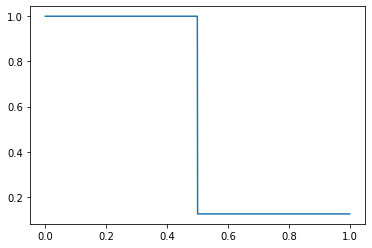

In [11]:
plt.plot(xx, rho0)

In [12]:
Pg, rho, moment, e, time= solver(nx, ny, nz, xx, nt, Pg0, rho0, u0, e0, method='LAX')

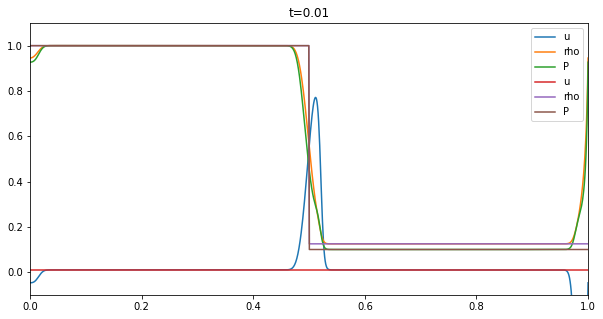

In [13]:
u = moment/rho
anim = animation(xx, time, u, rho, Pg, nt)
HTML(anim.to_jshtml())

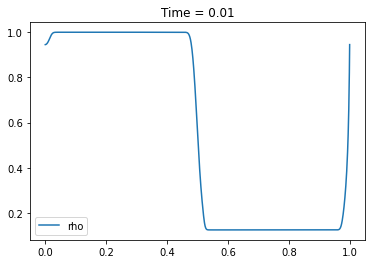

In [14]:
value = 0.2

t_idx = np.abs(time - value).argmin()
plt.plot(xx, rho[:, t_idx], label='rho')
plt.title(f'Time = {time[t_idx]:.2f}')
plt.legend()
plt.show()

In [15]:
x_sod, P_sod, rho_sod, u_sod, t_sod = nm.solve_sod_array(t_end=0.2, nt=100)

In [16]:
#anim = nm.animate_sod(x_sod, P_sod, rho_sod, u_sod, t_sod)
#HTML(anim.to_jshtml())

# Implementing several dimensions

In [121]:
def init_array3D(domain, nt, P0, rho0, u0, e0, γ=5/3):
    nx, ny, nz = domain
    e = np.zeros((nx, ny, nz, nt))
    Pg = np.zeros((nx, ny, nz, nt))
    moment = np.zeros((nx, ny, nz, nt))
    rho = np.zeros((nx, ny, nz, nt))
    u = np.zeros((nx, ny, nz, nt))

    e[:, :, :, 0] = e0
    Pg[:, :, :, 0] = P0
    rho[:, :, :, 0] = rho0
    u[:, :, :, 0] = u0
    moment[:, :, :, 0] = u0*rho0
    return Pg, e, moment, rho, u


def find_nan(arr, title, i):
    """
    Looks for nan values and breaks the loop
    """
    if np.any(np.isnan(arr)):
        print(f'{title} is nan at i: {i}')
        #print(arr)


def calculate_dt(xx, yy, zz, u, cs, eps, nx, ny, nz, idx_xx, idx_yy, idx_zz, debug=False):
    ans = []
    if nx > 1:
        ans.append(np.min(np.gradient(xx)) / np.max((np.abs(u[idx_xx]) + cs[idx_xx] + eps)))
    if nz > 1:
        ans.append(np.min(np.gradient(zz)) / np.max((np.abs(u[idx_zz]) + cs[idx_zz] + eps)))
    if ny > 1:
        ans.append(np.min(np.gradient(yy)) / np.max((np.abs(u[idx_yy]) + cs[idx_yy] + eps)))
    res = np.min(ans)
    if debug:
        print(f'max u : {np.max(u)}')
        print(f'max cs : {np.max(cs)}')
    return res


def init_arrayND(domain, nt, P0, rho0, u0, e0, γ=5/3):
    # TODO make cases for nx = nz = 1 and so on
    nx, ny, nz = domain
    if nx != ny and ny == 1 and nz == 1: 
        idx = (slice(None), 0)
        
    elif nx == ny and ny == nz:
        idx = (slice(None), slice(None), slice(None), 0)

    e = np.zeros((*domain, nt))
    Pg = np.zeros((*domain, nt))
    moment = np.zeros((*domain, nt))
    rho = np.zeros((*domain, nt))
    u = np.zeros((*domain, nt))

    e[idx] = e0
    Pg[idx] = P0
    rho[idx] = rho0
    u[idx] = u0
    moment[idx] = u0*rho0

    return Pg, e, moment, rho, u


def solverND(domain, xx, yy, zz, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1], debug=False):
    newax = np.newaxis
    nx, ny, nz = domain
    Pg, e, moment, rho, u = init_arrayND(domain, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1.e-10

    rho_rhs = np.zeros((domain))
    moment_rhs = np.zeros((domain))
    e_rhs = np.zeros((domain))

    for i in range(0, nt-1):
        # redo 1D case without indexing, hardcoding style
        """# For easier indexing
        if ny == 1 and nz == 1:
            idx = (slice(None), i)
            idx_x = (slice(None), slice(None), slice(None), i)
            idx_y = idx
            idx_z = idx
            idx_xx = slice(None)
            idx_yy = None
            idx_next = (slice(None), i+1)

        else:
            idx = (slice(None), slice(None), slice(None), i)
            idx_xx = (slice(None), 0, 0)
            idx_yy = (0, slice(None), 0)
            idx_zz = (0, 0, slice(None))
            idx_x = (slice(None), 0, 0, i)
            idx_y = (0, slice(None), 0, i)
            idx_z = (0, 0, slice(None), i)
            idx_next = (slice(None), slice(None), slice(None), i+1)
        """
        idx = (slice(None), slice(None), slice(None), i)
        idx_xx = (slice(None), 0, 0)
        idx_yy = (0, slice(None), 0)
        idx_zz = (0, 0, slice(None))
        idx_x = (slice(None), 0, 0, i)
        idx_y = (0, slice(None), 0, i)
        idx_z = (0, 0, slice(None), i)
        idx_next = (slice(None), slice(None), slice(None), i+1)

        """# For when the indexing work
        u = moment[idx]/(rho[idx] + eps)
        if nx == ny and nx == nz:
            ux = u[idx_xx]#moment[idx_x]/(rho[idx_x] + eps)
            uy = u[idx_yy]#moment[idx_y]/(rho[idx_y] + eps)
            uz = u[idx_zz]#moment[idx_z]/(rho[idx_z] + eps)
            
        else:
            ux = u[idx_xx] #moment[idx_x]/(rho[idx_x] + eps)
            uy = np.array([0.01])
            uz = np.array([0.01])

        num = γ*Pg_temp
        den = rho[idx] + eps
        arg = num/den
        cs = np.sqrt(arg)
        find_nan(num, 'num', i)
        find_nan(den, 'den', i)
        find_nan(arg, 'arg', i)
        """
        arg = np.abs(γ*Pg[idx] / (rho[idx] + eps))
        cs = np.sqrt(arg)
        # For the hardcoding part
        #Pg_temp = Pg[:, :, :, i]
        #cs = np.sqrt(γ * Pg_temp / (rho[:, :, :, i] + eps))
        find_nan(cs, 'cs', i)
        find_nan(rho[idx], 'rho', i)
        find_nan(Pg[idx], 'Pg', i)
        #find_nan(arg, 'arg', i)
        if debug:
            print('arg')
            print(arg)
            print('cs')
            print(cs)
            print(f'arg value with corresponding cs nan : {arg[np.where(np.isnan(cs) )]}')
            print(f'Pg value with corresponding cs nan : {Pg[idx][np.where(np.isnan(cs) )]}')
            print(f'rho value with corresponding cs nan : {rho[idx][np.where(np.isnan(cs) )]}')

        u = moment[idx]/(rho[idx] + eps)
        ux = u[idx_xx]
        uy = u[idx_yy]
        uz = u[idx_zz]
        # cfl condition
        dt = cfl_cut*(calculate_dt(xx, yy, zz, u, cs, eps, nx, ny, nz, idx_xx, idx_yy, idx_zz))
        if dt < 0:
            print(f'dt negative: {i}')
            break
        find_nan(dt, 'dt', i)
        if np.any(np.isnan(dt)):
            return Pg, rho, moment, e, time
        if debug:
            print(f'ux: {ux.shape}')
            print(f'uy: {uy.shape}')
            print(f'uz: {uz.shape}')
            print(f'yy: {yy.shape}')
            #print(f'{yy}')
            print(f'rho: {rho[0, :, 0, i].shape}')
            print(f'cs: {cs.shape}')
            print(f'dt: {dt}')
            print(f'min num : {np.min(num)}')
            print(f'min den : {np.min(den)}')
            print(f'min arg : {np.min(arg)}')
            print(f'min cs : {np.min(cs)}')
            print(f'rho[idx_x] shape: {rho[idx_x].shape}')
            print(f'rho[idx_y] shape: {rho[idx_y].shape}')
            print(f'rho[idx_z] shape: {rho[idx_z].shape}')
            print(f'ux shape: {ux.shape}')
            print(f'uy shape: {uy.shape}')
            print(f'uz shape: {uz.shape}')
            print(f'Pg_temp[idx_xx] shape: {Pg_temp[idx_xx].shape}')
            print(f'xx shape: {xx.shape}')
            print(f'yy shape: {yy.shape}')
            print(f'zz shape: {zz.shape}')
            print(f'moment_rhs[idx_yy] : {moment_rhs[idx_yy].shape}')


        # Split the operations into many if statements
        # because need to check the value for nN
        if nx > 1:
            # ux for when indexing work
            rho_rhs[idx_xx] = -ddx(xx, rho[idx_x]*ux)
        if ny > 1:
            rho_rhs[idx_yy] = -ddx(yy, rho[idx_y]*uy)
        if nz > 1:
            rho_rhs[idx_zz] = -ddx(zz, rho[idx_z]*uz)

        # Momentum equation
        moment_rhs_x = 0.
        moment_rhs_y = 0. 
        moment_rhs_z = 0.
        if nx > 1:
            moment_rhs_x += -(ddx(xx, moment[idx_x]*ux + Pg[idx_x]))
            # TODO Aske about the moment below
            moment_rhs_y += -(ddx(xx, rho[idx_x]*uy*uy))
            moment_rhs_z += -(ddx(xx, rho[idx_x]*uz*uz))
        if ny > 1:
            moment_rhs_x += -(ddx(yy, rho[idx_y]*ux*uy))
            moment_rhs_y += -(ddx(yy, rho[idx_y]*ux*uy) + Pg[idx_y])
            moment_rhs_z += -(ddx(yy, rho[idx_y]*uy*uz))
        if nz > 1:
            moment_rhs_x += -(ddx(zz, rho[idx_z]*ux*uz))
            moment_rhs_y += -(ddx(zz, rho[idx_z]*uz*uy))
            moment_rhs_z += -(ddx(zz, rho[idx_z]*ux*uz) + Pg[idx_z])
            
        if nx > 1:
            moment_rhs[idx_xx] = moment_rhs_x
        if ny > 1:
            moment_rhs[idx_yy] = moment_rhs_y
        if nz > 1:
            moment_rhs[idx_zz] = moment_rhs_z


        if nx > 1:
            e_rhs[idx_xx] = -(ddx(xx, e[idx_x]*ux) + Pg[idx_x]*ddx(xx, ux))
        if ny > 1:
            e_rhs[idx_yy] = -(ddx(yy, e[idx_y]*uy) + Pg[idx_y]*ddx(yy, uy))
        if nz > 1:
            e_rhs[idx_zz] = -(ddx(zz, e[idx_z]*uz) + Pg[idx_z]*ddx(zz, uz))


        if method == 'FTCS':
            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt

        elif method == 'LAX':
            rho_lax = np.zeros((domain))
            moment_lax = np.zeros((domain))
            e_lax = np.zeros((domain))
            if nx > 1:
                rho_lax[idx_xx] = (np.roll(rho[idx_x], -1) + rho[idx_x] + np.roll(rho[idx_x], 1))/ 3.
                moment_lax[idx_xx] = (np.roll(moment[idx_x], -1) + moment[idx_x] + np.roll(moment[idx_x], 1))/ 3.
                e_lax[idx_xx] = (np.roll(e[idx_x], -1) + e[idx_x] + np.roll(e[idx_x], 1))/ 3.
            if ny > 1:
                rho_lax[idx_yy] = (np.roll(rho[idx_y], -1) + rho[idx_y] + np.roll(rho[idx_y], 1))/ 3.
                moment_lax[idx_yy] = (np.roll(moment[idx_y], -1) + moment[idx_y] + np.roll(moment[idx_y], 1))/ 3.
                e_lax[idx_yy] = (np.roll(e[idx_y], -1) + e[idx_y] + np.roll(e[idx_y], 1))/ 3.
            if nz > 1:
                rho_lax[idx_zz] = (np.roll(rho[idx_z], -1) + rho[idx_z] + np.roll(rho[idx_z], 1))/ 3.
                moment_lax[idx_zz] = (np.roll(moment[idx_z], -1) + moment[idx_z] + np.roll(moment[idx_z], 1))/ 3.
                e_lax[idx_zz] = (np.roll(e[idx_z], -1) + e[idx_z] + np.roll(e[idx_z], 1))/ 3.
                
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt

        find_nan(rho_rhs, 'rho_rhs', i)
        find_nan(rho[idx], 'rho[idx]', i)
        find_nan(dt, 'dt', i)
        if np.any(np.isnan(rho_temp)):
            print(f'rho_temp nan at i: {i}')
            return Pg, rho, moment, e, time
            
        # Boundary conditions TODO fix the else statement
        if nx > 1:
            if bnd_limits[1] > 0:  # up and centre
                rho_bc_x = rho_temp[idx_xx][bnd_limits[0]: -bnd_limits[1]]
                moment_bc_x = moment_temp[idx_xx][bnd_limits[0]: -bnd_limits[1]]
                e_bc_x = e_temp[idx_xx][bnd_limits[0]: -bnd_limits[1]]
            else:
                rho_bc_x = rho_temp[bnd_limits[0]:]
                moment_bc_x = moment_temp[bnd_limits[0]:]
                e_bc_x = e_temp[bnd_limits[0]:]
            rho[:, 0, 0, i+1] = np.pad(rho_bc_x, bnd_limits, bnd_type)
            moment[:, 0, 0, i+1] = np.pad(moment_bc_x, bnd_limits, bnd_type)
            e[:, 0, 0, i+1] = np.pad(e_bc_x, bnd_limits, bnd_type)

        if ny > 1:        
            if bnd_limits[1] > 0:  # up and centre
                rho_bc_y = rho_temp[idx_yy][bnd_limits[0]: -bnd_limits[1]]
                moment_bc_y = moment_temp[idx_yy][bnd_limits[0]: -bnd_limits[1]]
                e_bc_y = e_temp[idx_yy][bnd_limits[0]: -bnd_limits[1]]
            else:
                rho_bc = rho_temp[bnd_limits[0]:]
                moment_bc = moment_temp[bnd_limits[0]:]
                e_bc = e_temp[bnd_limits[0]:]
            rho[0, :, 0, i+1] = np.pad(rho_bc_y, bnd_limits, bnd_type)
            moment[0, :, 0, i+1] = np.pad(moment_bc_y, bnd_limits, bnd_type)
            e[0, :, 0, i+1] = np.pad(e_bc_y, bnd_limits, bnd_type)
        if nz > 1:
            if bnd_limits[1] > 0:  # up and centre
                rho_bc_z = rho_temp[idx_zz][bnd_limits[0]: -bnd_limits[1]]
                moment_bc_z = moment_temp[idx_zz][bnd_limits[0]: -bnd_limits[1]]
                e_bc_z = e_temp[idx_zz][bnd_limits[0]: -bnd_limits[1]]
            else:
                rho_bc = rho_temp[bnd_limits[0]:]
                moment_bc = moment_temp[bnd_limits[0]:]
                e_bc = e_temp[bnd_limits[0]:]
            rho[0, 0, :, i+1] = np.pad(rho_bc_z, bnd_limits, bnd_type)
            moment[0, 0, :, i+1] = np.pad(moment_bc_z, bnd_limits, bnd_type)
            e[0, 0, :, i+1] = np.pad(e_bc_z, bnd_limits, bnd_type)

        """
        if nx > 1 and ny > 1 and nz > 1:
            bc_domain = (nx-1, ny-1, nz-1)
            bc_x = (slice(None), 0, 0)
            bc_y = (0, slice(None), 0)
            bc_z = (0, 0, slice(None))
        elif nx > 1 and ny > 1 and nz == 1:
            bc_domain = (nx-1, ny-1)
            bc_x = (slice(None), 0)
            bc_y = (0, slice(None))
        else: # The case where ny=nz=1
            bc_domain = (nx-1)
            bc_x = (slice(None))
        rho_bc = np.zeros((bc_domain))  # Initialize boundary condition array
        moment_bc = np.zeros((bc_domain))
        e_bc = np.zeros((bc_domain))
        # Assign boundary conditions based on dimensions
        if nx > 1:
            rho_bc = rho_bc_x
            moment_bc = moment_bc_x
            e_bc = e_bc_x
        """
        """# Trying to boundary each axis alone
        rho_bc[bc_x] = rho_bc_x
        moment_bc[bc_x] = moment_bc_x
        e_bc[bc_x] = e_bc_x
        if ny > 1:
            rho_bc[bc_y] = rho_bc_y
            moment_bc[bc_y] = moment_bc_y
            e_bc[bc_y] = e_bc_y

        if nz > 1:
            rho_bc[bc_z] = rho_bc_z
            moment_bc[bc_z] = moment_bc_z
            e_bc[bc_z] = e_bc_z
            
        
        #print(f'rho_bc : {rho_bc_x.shape}')
        # Variable update
        if nx > 1:
            rho[idx_next] = np.pad(rho_bc_x, bnd_limits, bnd_type).reshape(domain)
            moment[idx_next] = np.pad(moment_bc_x, bnd_limits, bnd_type).reshape(domain)
            e[idx_next] = np.pad(e_bc_x, bnd_limits, bnd_type).reshape(domain)
        #rho[idx_next] = np.pad(rho_bc, bnd_limits, bnd_type).reshape(domain)
        """
        if np.any(np.isnan(rho[idx_next])):
            print(f'rho nan value i: {i}')
            return Pg, rho, moment, e, time

        Pg_temp = (γ - 1) * e[idx_next]
        if np.any(np.isnan(Pg_temp)):
            print(f'Pg nan value i: {i}')
            return Pg, rho, moment, e, time
        Pg[idx_next] = Pg_temp

        time[i+1] = time[i] + dt

    return Pg, rho, moment, e, time


def solver3D(domain, xx, yy, zz, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1], debug=False):
    newax = np.newaxis
    allow = 0
    nx, ny, nz = domain
    Pg, e, moment, rho, u = init_array3D(domain, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    cs_list = []

    rho_rhs = np.zeros((nx, ny, nz))
    moment_rhs = np.zeros((nx, ny, nz))
    e_rhs = np.zeros((nx, ny, nz))
    for i in range(0, nt-1):
        u = moment[:, :, :, i]/(rho[:, :, :, i] + eps)
        ux = moment[:, 0, 0, i]/(rho[:, 0, 0, i] + eps)
        uy = moment[0, :, 0, i]/(rho[0, :, 0, i] + eps)
        uz = moment[0, 0, :, i]/(rho[0, 0, :, i] + eps)
        Pg_temp = Pg[:, :, :, i]
        num = γ*Pg_temp
        den = rho[:, :, :, i] + eps
        arg = num/den
        cs = np.sqrt(arg)

        find_nan(rho[:, :, :, i], 'rho', i)
        find_nan(Pg_temp, 'Pg', i)
        find_nan(num, 'num', i)
        find_nan(den, 'den', i)
        find_nan(arg, 'arg', i)
        find_nan(cs, 'cs', i)

        # cfl condition
        #dt1 = np.min(calculate_dt(xx, yy, zz, u, cs0, eps, nx, ny, nz))

        dt = np.min(calculate_dt(xx, yy, zz, u, cs, eps, nx, ny, nz))

        #dt3 = np.min(calculate_dt(xx, yy, zz, u, -cs, eps, nx, ny, nz))

        #dt = cfl_cut*np.min([dt1, dt2, dt3])
        dt *= cfl_cut
        if dt < 0:
            print(f'dt negative: {i}')
            break
        find_nan(dt, 'dt', i)
        if debug:
            print(f'ux: {ux.shape}')
            print(f'uy: {uy.shape}')
            print(f'uz: {uz.shape}')
            print(f'yy: {yy.shape}')
            print(f'{yy}')
            print(f'rho: {rho[0, :, 0, i].shape}')
            print(f'cs: {cs.shape}')
            print(f'dt: {dt}')
            print(f'min num : {np.min(num)}')
            print(f'min den : {np.min(den)}')
            print(f'min arg : {np.min(arg)}')
            print(f'min cs : {np.min(cs)}')
        # For easier indexing
        idx = (slice(None), slice(None), slice(None), i)
        idx_xx = (slice(None), 0, 0)
        idx_yy = (0, slice(None), 0)
        idx_zz = (0, 0, slice(None))
        idx_x = (slice(None), 0, 0, i)
        idx_y = (0, slice(None), 0, i)
        idx_z = (0, 0, slice(None), i)
        if method == 'FTCS':

            rho_rhs[idx_xx] = -ddx(xx, rho[idx_x]*ux)
            rho_rhs[idx_yy] = -ddx(yy, rho[idx_y]*uy)
            rho_rhs[idx_zz] = -ddx(zz, rho[idx_z]*uz)

            if debug:
                print(f'rho[idx_x] shape: {rho[idx_x].shape}')
                print(f'rho[idx_y] shape: {rho[idx_y].shape}')
                print(f'rho[idx_z] shape: {rho[idx_z].shape}')
                print(f'ux shape: {ux.shape}')
                print(f'uy shape: {uy.shape}')
                print(f'uz shape: {uz.shape}')
                print(f'Pg_temp[idx_xx] shape: {Pg_temp[idx_xx].shape}')
                print(f'xx shape: {xx.shape}')
                print(f'yy shape: {yy.shape}')
                print(f'zz shape: {zz.shape}')
                print(f'moment_rhs[idx_yy] : {moment_rhs[idx_yy].shape}')

            # TODO the calculations on the right side has array length 64

            # This is okey, because left side (64,) and right side (64,)
            moment_rhs[idx_xx] = (-(ddx(xx, rho[idx_x]*ux*ux)
                                    + ddx(yy, rho[idx_y]*ux*uy)
                                    + ddx(zz, rho[idx_z]*ux*uz)
                                    + ddx(xx, Pg_temp[idx_xx])))
            # make if statements per spatial axis and nx
            # if nx > 1:
            # do ddx(xx, rhoux)

            # These is not okey, because left side (1,) and right side (64,)
            moment_rhs[idx_yy] = (-(ddx(yy, rho[idx_y]*ux*uy)
                                    + ddx(xx, rho[idx_x]*uy*uy)
                                    + ddx(zz, rho[idx_z]*uz*uy)
                                    + ddx(yy, Pg_temp[idx_yy])))
            moment_rhs[idx_zz] = (-(ddx(zz, rho[idx_z]*ux*uz)
                                    + ddx(yy, rho[idx_y]*uy*uz)
                                    + ddx(xx, rho[idx_x]*uz*uz)
                                    + ddx(zz, Pg_temp[idx_zz])))

            e_rhs[idx_xx] = -(ddx(xx, e[idx_x]*ux) -
                              Pg_temp[idx_xx]*ddx(xx, ux))

            e_rhs[idx_yy] = -(ddx(yy, e[idx_y]*uy) -
                              Pg_temp[idx_yy]*ddx(yy, uy))
            e_rhs[idx_zz] = -(ddx(zz, e[idx_z]*uz) -
                              Pg_temp[idx_zz]*ddx(zz, uz))

            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt

            if np.any(np.isnan(rho_temp)):
                print(f'rho_temp nan at i: {i}')
                print(rho_temp)
                return Pg, rho, moment, e, time


        elif method == 'LAX':
            rho_lax = ((np.roll(rho[idx_x], -1) + rho[idx_x] + np.roll(rho[idx_x], 1))/3
                       + (np.roll(rho[idx_y], -1) +
                          rho[idx_y] + np.roll(rho[idx_y], 1))/3
                       + (np.roll(rho[idx_z], -1) + rho[idx_z] + np.roll(rho[idx_z], 1))/3)

            moment_lax = ((np.roll(moment[idx_x], -1) + moment[idx_x] + np.roll(moment[idx_x], 1))/3
                          + (np.roll(moment[idx_y], -1) +
                             moment[idx_y] + np.roll(moment[idx_y], 1))/3
                          + (np.roll(moment[idx_z], -1) + moment[idx_z] + np.roll(moment[idx_z], 1))/3)

            e_lax = ((np.roll(e[idx_x], -1) + e[idx_x] + np.roll(e[idx_x], 1))/3
                     + (np.roll(e[idx_y], -1) +
                        e[idx_y] + np.roll(e[idx_y], 1))/3
                     + (np.roll(e[idx_z], -1) + e[idx_z] + np.roll(e[idx_z], 1))/3)

            rho_rhs[idx_xx] = np.nan_to_num(-ddx(xx, rho[idx_x]*ux), nan=0)
            rho_rhs[idx_yy] = np.nan_to_num(-ddx(yy, rho[idx_y]*uy), nan=0)
            rho_rhs[idx_zz] = np.nan_to_num(-ddx(zz, rho[idx_z]*uz), nan=0)

            moment_rhs[idx_xx] = np.nan_to_num(-(ddx(xx, rho[idx_x]*ux*ux)
                                                 + ddx(yy, rho[idx_y]*ux*uy)
                                                 + ddx(zz, rho[idx_z]*ux*uz)
                                                 + ddx(xx, Pg_temp[idx_xx])), nan=0)
            moment_rhs[idx_yy] = np.nan_to_num(-(ddx(yy, rho[idx_y]*ux*uy)
                                                 + ddx(xx, rho[idx_x]*uy*uy)
                                                 + ddx(zz, rho[idx_z]*uz*uy)
                                                 + ddx(yy, Pg_temp[idx_yy])), nan=0)
            moment_rhs[idx_zz] = np.nan_to_num(-(ddx(zz, rho[idx_z]*ux*uz)
                                                 + ddx(yy, rho[idx_y]*uy*uz)
                                                 + ddx(xx, rho[idx_x]*uz*uz)
                                                 + ddx(zz, Pg_temp[idx_zz])), nan=0)
            e_rhs[idx_xx] = np.nan_to_num(-(ddx(xx, e[idx_x]*ux) -
                                          Pg_temp[idx_xx]*ddx(xx, ux)), nan=0)
            e_rhs[idx_yy] = np.nan_to_num(-(ddx(yy, e[idx_y]*uy) -
                                          Pg_temp[idx_yy]*ddx(yy, uy)), nan=0)
            e_rhs[idx_zz] = np.nan_to_num(-(ddx(zz, e[idx_z]*uz) -
                                          Pg_temp[idx_zz]*ddx(zz, uz)), nan=0)

            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt

            if np.any(np.isnan(rho_temp)):
                print(f'rho_temp nan at i: {i}')
                print(rho_temp)
                return Pg, rho, moment, e, time

        # Boundary conditions
        # pad per axis
        # if statement for x axis then bnd_limits
        #if nx > 1:

        if bnd_limits[1] > 0:  # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1],
                              bnd_limits[0]:-bnd_limits[1], bnd_limits[0]:-bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1],
                                    bnd_limits[0]:-bnd_limits[1], bnd_limits[0]:-bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1], bnd_limits[0]:-bnd_limits[1], bnd_limits[0]:-bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]

        # Variable update
        rho[:, :, :, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        if np.any(np.isnan(rho[:, :, :, i+1])):
            print(f'rho nan value i: {i}')
        moment[:, :, :, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, :, :, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        """
        rho[:, :, :, i+1] = rho_temp
        moment[:, :, :, i+1] = moment_temp
        e[:, :, :, i+1] = e_temp
        """

        Pg_temp = (γ - 1) * e[:, :, :, i+1]
        if np.any(np.isnan(Pg_temp)):
            print(f'Pg nan value i: {i}')
            return Pg, rho, moment, e, time
        Pg[:, :, :, i+1] = Pg_temp

        time[i+1] = time[i] + dt

    return Pg, rho, moment, e, time


def gauss3D(xx, yy, zz, A, mu, sigma, C):
    x_term = -.5*(xx - mu[0])**2 / sigma[0]**2
    y_term = -.5*(yy - mu[1])**2 / sigma[1]**2
    z_term = -.5*(zz - mu[2])**2 / sigma[2]**2
    exponent = x_term + y_term + z_term
    ans = A * np.exp(exponent) + C
    return ans


## Testing on gaussian `(nx, 1, 1)`

In [109]:
γ = 5/3
nt = 100
nx, ny, nz = 1024, 1, 1


domain = (nx, ny, nz)
xx = nm.spatial_domain(nx, x0=0, xf=1)#np.linspace(0, 1, nx)
yy = nm.spatial_domain(ny, x0=0, xf=1)
zz = nm.spatial_domain(nz, x0=0, xf=1)

u01D = np.zeros(nx)+0.01
e01D = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.1)) + 0.1
Pg01D = (γ - 1)*e01D 
rho01D = np.ones(nx)#gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.01)) + 0.1

A = 1
#mu = [0.5, 0.5, 0.5]
#sigma = [0.1, 0.1, 0.1]
mu = 0.5
sigma = 0.01
C = 0.1

In [110]:
u0 = np.zeros((nx, ny, nz))
u0[:, 0, 0] = 0.01
e0 = np.zeros((nx, ny, nz))
e0[:, 0, 0] = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)
#e0 = gauss3D(xx[:, np.newaxis, np.newaxis], yy, zz, 1, mu, sigma, C=0.1)
#e0 = e0.reshape(domain)
Pg0 = (γ - 1)*e0 
rho0 = np.zeros((nx, ny, nz))
rho0[:, 0, 0] = 1.
#rho0 = np.ones((nx, ny, nz))

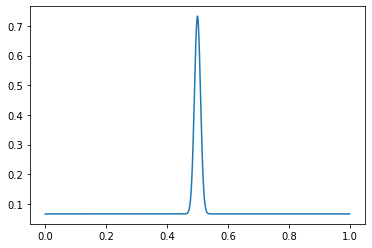

In [111]:
plt.plot(xx, Pg0[:, 0, 0])

In [120]:
importlib.reload(nm)
met = 'FTCS'
Pg1D, rho1D, moment1D, e1D, time1D = solver(nx, ny, nz, xx, nt, Pg01D, rho01D, u01D, e01D, method=met)
#Pg, rho, moment, e, time = solver3D(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0, method='FTCS')
Pg, rho, moment, e, time = solverND(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0, method=met)
#args = solver3D(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0)
#
#
u1D = moment1D/rho1D
u = moment/rho

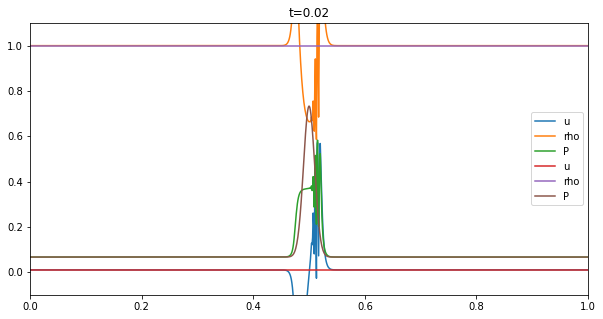

In [113]:
anim = animation(xx, time1D, u1D, rho1D, Pg1D, nt)
HTML(anim.to_jshtml())

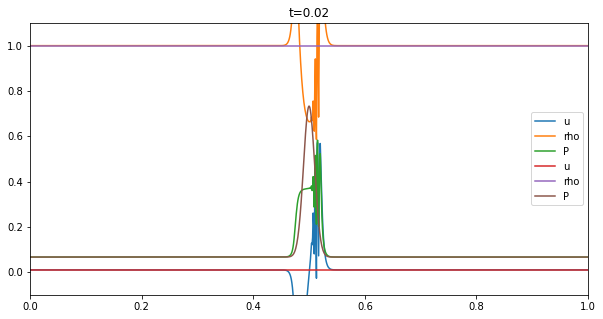

In [114]:
u = moment/rho
anim = animation(xx, time, u[:, 0, 0], rho[:, 0, 0], Pg[:, 0, 0], nt)
HTML(anim.to_jshtml())

In [22]:
print(rho1D[:, 3] - rho[:, 0, 0, 3])

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

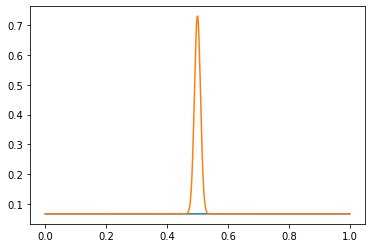

In [ ]:
plt.plot(xx, Pg[:, 0, 0, 1])
plt.plot(xx, Pg1D[:, 1])

Text(0.5, 1.0, 't=0.11202162502432128')

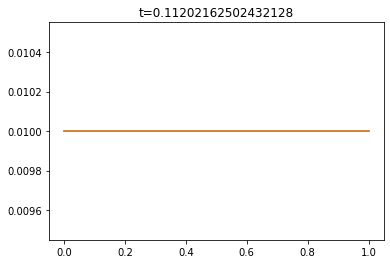

In [ ]:
t_idx = np.nanargmax(time)
plt.plot(xx, u[:, 0, 0, 0])
plt.plot(xx, u[:, 0, 0, -1])
plt.title(f't={time[-1]}')